In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRume
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRume.build(
    ipm=Sirh(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", 7 * 53 + 1),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

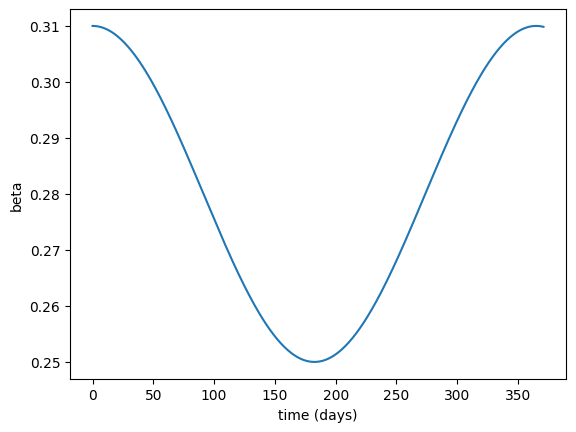

In [2]:
import matplotlib.pyplot as plt

plt.plot(t, true_beta)
plt.ylabel("beta")
plt.xlabel("time (days)")
# plt.ylim(0, 0.4)
plt.show()

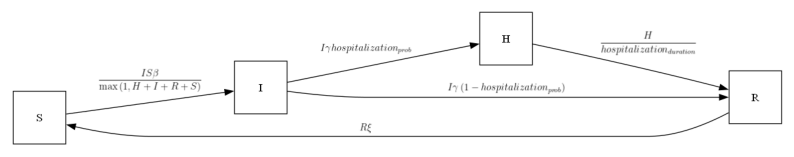

In [3]:
rume.ipm.diagram()

In [4]:
from epymorph.log.messaging import sim_messaging
from epymorph.simulator.basic.basic_simulator import BasicSimulator

rng = np.random.default_rng(seed=1)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run(rng_factory=(lambda: rng))

Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (1.513s)
Running simulation (BasicSimulator):
• 2022-10-01 to 2023-10-07 (372 days)
• 1 geo nodes
  |####################| 100%                     
Runtime: 0.047s


In [5]:
from epymorph.time import EveryNDays
from epymorph.tools.data import munge

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

cases_df = munge(
    out,
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

cases_df.to_csv("./doc/devlog/data/temp_synthetic_data.csv", index=False)

In [6]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [7]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood.poisson import PoissonLikelihood
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=PoissonLikelihood(),
)

filter_type = ParticleFilter(num_particles=500)

In [ ]:
from epymorph.parameter_fitting.distributions.uniform import Uniform
from epymorph.parameter_fitting.dynamics.dynamics import (
    GeometricBrownianMotion,
)

from epymorph.parameter_fitting.perturbation.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [9]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

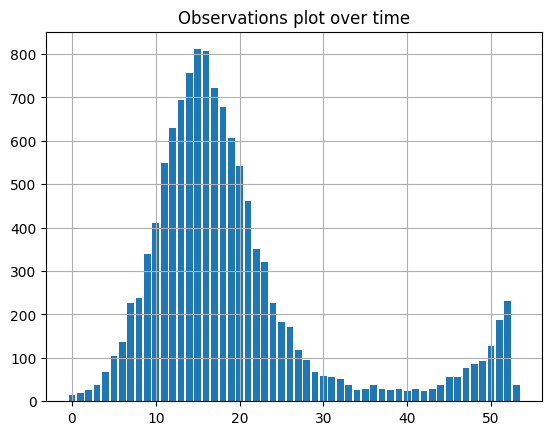

In [10]:
sim.plot_data()

In [11]:
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 500 particles

Simulation completed in 271.75s

Parameters estimated: ['beta', 'xi']


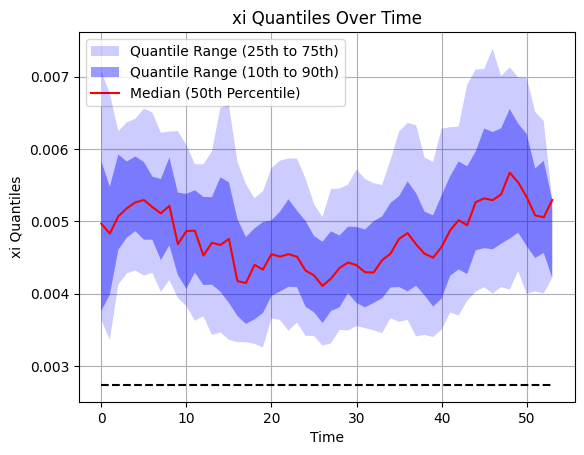

In [12]:
from epymorph.database import NamePattern
from epymorph.parameter_fitting.utils import plots


plots.params_plot(
    output=output,
    key="xi",
    node_index=0,
    truth=rume.params[NamePattern(strata="*", module="*", id="xi")],
)


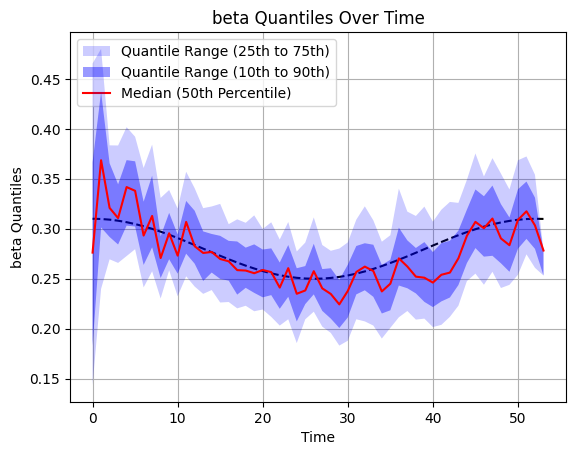

In [18]:
plots.params_plot(
    output=output,
    key="beta",
    node_index=0,
    truth=rume.params[NamePattern(strata="*", module="*", id="beta")][::7],
)


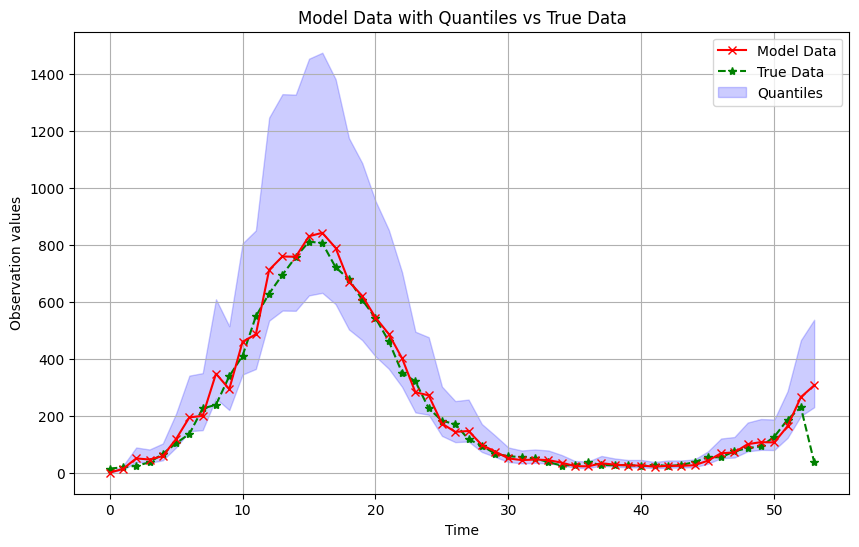

In [14]:
plots.model_fit(output=output, node_index=0)

In [15]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/influenza.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [16]:
from epymorph.adrio.cdc import InfluenzaHospitalizationSumState
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood.poisson import PoissonLikelihood
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

observations = Observations(
    # source=csvadrio,
    source=InfluenzaHospitalizationSumState(),
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=PoissonLikelihood(),
)

In [17]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)
sim.plot_data()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)>

In [18]:
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 2000 particles

Simulation completed in 699.08s

Parameters estimated: ['beta', 'xi']


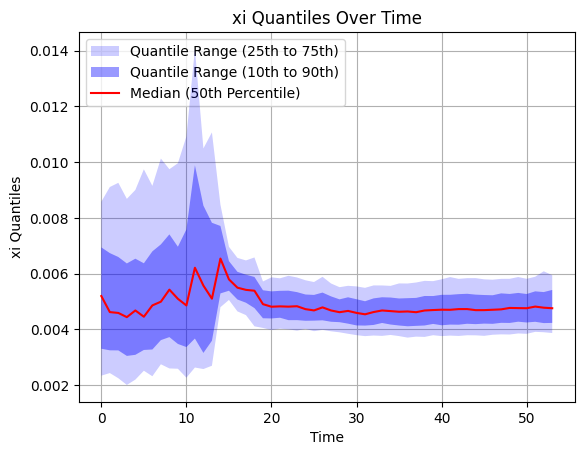

In [19]:
plots.params_plot(
    output=output,
    key="xi",
    node_index=0,
)

# plots.params_plot(
#     output=output,
#     key="hospitalization_prob",
#     node_index=0,
# )

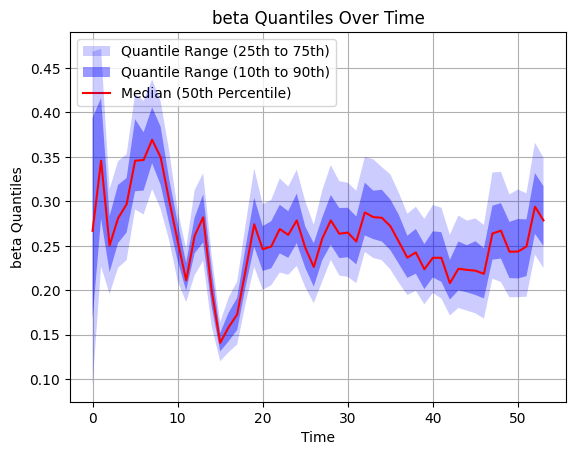

In [20]:
plots.params_plot(
    output=output,
    key="beta",
    node_index=0,
)


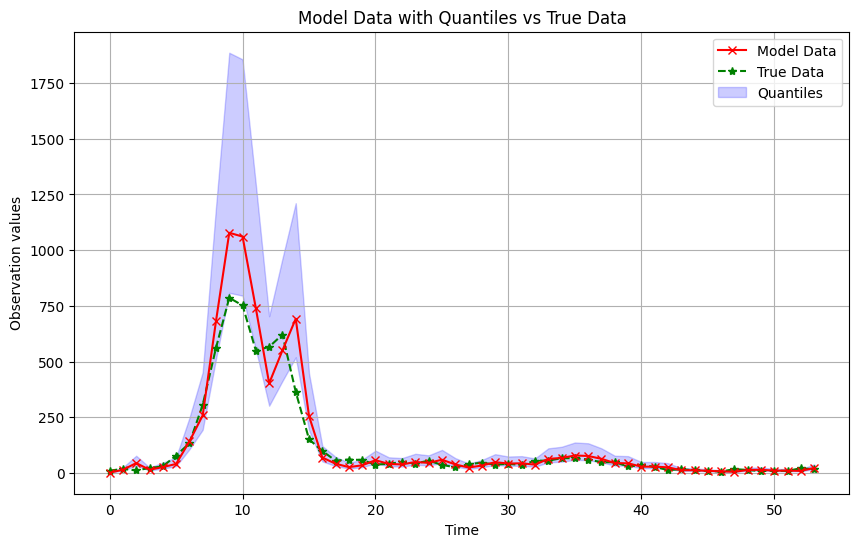

In [21]:
plots.model_fit(output=output, node_index=0)